In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-practice-dataset/train.csv
/kaggle/input/time-series-practice-dataset/test.csv


**Load and Preprocess the Data**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
train_data_path = '/kaggle/input/time-series-practice-dataset/train.csv'
test_data_path = '/kaggle/input/time-series-practice-dataset/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Combine train and test data for preprocessing
data = pd.concat([train_data, test_data], axis=0)

# Extract the necessary columns
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['number_sold']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for RNN
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


**RNN MODEL**

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


2024-07-13 05:15:10.488251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 05:15:10.488377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 05:15:10.625544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**TRAIN THE MODEL**

In [4]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - loss: 0.0033 - val_loss: 3.6546e-04
Epoch 2/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 6.0167e-04 - val_loss: 4.1152e-04
Epoch 3/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 5.5817e-04 - val_loss: 3.8982e-04
Epoch 4/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 5.4494e-04 - val_loss: 3.0977e-04
Epoch 5/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 4.7420e-04 - val_loss: 2.8863e-04
Epoch 6/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - loss: 4.6336e-04 - val_loss: 2.5905e-04
Epoch 7/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 4.5091e-04 - val_loss: 2.8265e-04
Epoch 8/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 4.4825e-04 - val_loss: 2.8157e-04
Epoch 9/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 4.4388e-04 - val_loss: 2.4964e-04
Epoch 10/50
6390/6390 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step - loss: 4.4226e-04 - val_loss: 2.7195e-04
Epoch 11/50
6390/6390 ━━

**VALIDATE THE MODEL**

1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


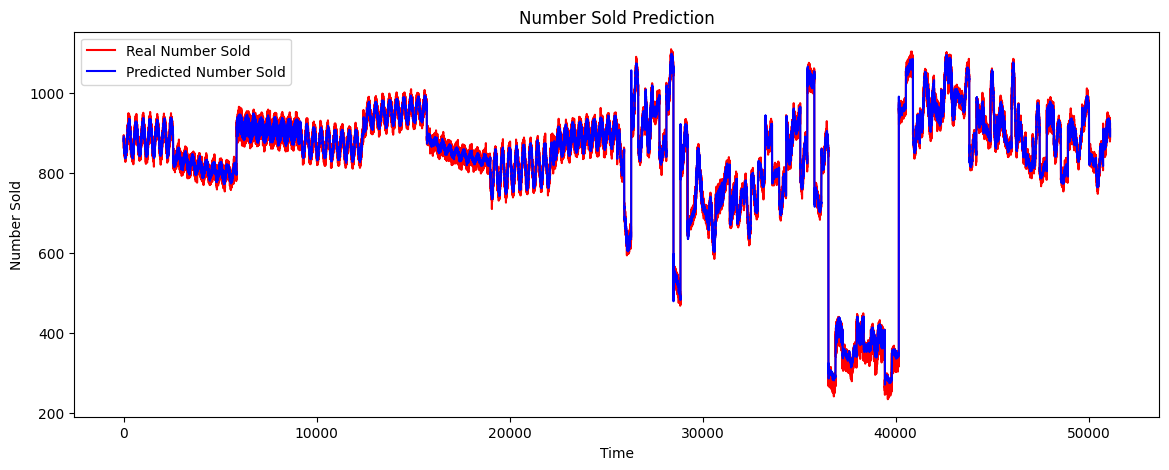

In [5]:
# Predicting the number sold using the validation set
predicted_number_sold = model.predict(X_val)
predicted_number_sold = scaler.inverse_transform(predicted_number_sold.reshape(-1, 1))

# Inverse transform the y_val to its original scale
real_number_sold = scaler.inverse_transform(y_val.reshape(-1, 1))

# Visualizing the results
plt.figure(figsize=(14, 5))
plt.plot(real_number_sold, color='red', label='Real Number Sold')
plt.plot(predicted_number_sold, color='blue', label='Predicted Number Sold')
plt.title('Number Sold Prediction')
plt.xlabel('Time')
plt.ylabel('Number Sold')
plt.legend()
plt.show()
